<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=142459154" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = True
cboe_years = [2014,2015,2016]
load_tradier = False

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.005,0.45),
    'lp':(0.002,''),
    'sc':(0.005,0.45),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs = {}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 10


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to ou

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:
    files = []
    for cboe_year in cboe_years:
        files.append(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_pyvollib_spx_{cboe_year}_1dte_all.csv")
        
    dfs = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return']

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-09-09 17:23:54,096] A new study created in RDB with name: DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_cboe_140102_161230_spx_st_0_simuledge_0
[I 2023-09-09 17:23:57,643] Trial 0 finished with value: -1.799 and parameters: {'sp': 0.02447700298229922, 'lp': 0.0158939469154279, 'sc': 0.01582783024234672, 'lc': 0.008864784577657391}. Best is trial 0 with value: -1.799.


[I 2023-09-09 17:24:00,517] Trial 1 finished with value: 11.127 and parameters: {'sp': 0.10118909364692256, 'lp': 0.022085792406147796, 'sc': 0.005747142647111112, 'lc': 0.0022552860953950747}. Best is trial 1 with value: 11.127.
[I 2023-09-09 17:24:03,535] Trial 2 finished with value: -9.007 and parameters: {'sp': 0.10112739884305176, 'lp': 0.09307274629446305, 'sc': 0.15379575764059342, 'lc': 0.056534178794905444}. Best is trial 1 with value: 11.127.
[I 2023-09-09 17:24:06,422] Trial 3 finished with value: -5.306 and parameters: {'sp': 0.11309072117479352, 'lp': 0.1032178009548448, 'sc': 0.26375686366374174, 'lc': 0.05274304604536489}. Best is trial 1 with value: 11.127.
[I 2023-09-09 17:24:09,327] Trial 4 finished with value: -2.732 and parameters: {'sp': 0.3732187353105208, 'lp': 0.0964056332805215, 'sc': 0.43196824239021847, 'lc': 0.02913726590679222}. Best is trial 1 with value: 11.127.
[I 2023-09-09 17:24:12,211] Trial 5 finished with value: -2.307 and parameters: {'sp': 0.35888

Best Score:  11.127
Best Params: 
  lc: 0.0022552860953950747
  lp: 0.022085792406147796
  sc: 0.005747142647111112
  sp: 0.10118909364692256


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                11.127
Max Drawdown                                     -3.713
Mean Win Trans Return                             0.121
Mean Loss Trans Return                           -1.973
Mean Trans Return                                 0.055
Std Dev of Trans Return                           0.006
Sharpe Ratio static STD                           1.536
Sharpe Ratio with RF STD                          1.536
Risk Adj Cumulative Return                     1975.106
Dampened Risk Adj Cumulative Return             148.245
Trading Days                                        193
Wins                                                186
Losses                                                6
Breakeven                                             1
Win/Loss Ratio                                   96.373
Mean Win                                         46.782
Mean Loss                                      -780.833
Mean Net Trans    

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,short_long_balance_call,short_long_balance_put
0,2014-01-02,2014-01-03,4,1810.0,1875.0,1910.0,1775.0,0.101189,0.085640,40.0,0.005747,0.004478,0.0,0.002255,0.002229,-5.0,0.022086,0.021172,-17.5,17.5,0.0,0.0,1831.47,6.0,0.0,11.5,36855.1,11.5,0.000312,0.000312,2.301587e-06,0,0
1,2014-01-09,2014-01-10,4,1815.0,1885.0,1915.0,1785.0,0.101189,0.089857,57.5,0.005747,0.004349,0.0,0.002255,0.002245,-5.0,0.022086,0.019126,-15.0,37.5,0.0,0.0,1842.37,6.0,0.0,31.5,36886.6,43.0,0.000855,0.001167,1.309524e-06,0,0
2,2014-01-23,2014-01-24,4,1805.0,1875.0,1905.0,1770.0,0.101189,0.083582,45.0,0.005747,0.003817,0.0,0.002255,0.002246,-5.0,0.022086,0.021749,-20.0,20.0,0.0,1425.0,1790.75,6.0,1425.0,-1411.0,35475.6,-1368.0,-0.038252,-0.037130,1.190476e-06,0,0
3,2014-01-30,2014-01-31,4,1770.0,1850.0,1880.0,1735.0,0.101189,0.097419,70.0,0.005747,0.003798,0.0,0.002255,0.002181,-5.0,0.022086,0.021276,-20.0,45.0,0.0,0.0,1782.48,6.0,0.0,39.0,35514.6,-1329.0,0.001099,-0.036071,5.952381e-07,0,0
4,2014-02-06,2014-02-07,4,1735.0,1830.0,1855.0,1700.0,0.101189,0.084486,95.0,0.005747,0.005379,5.0,0.002255,0.002217,-5.0,0.022086,0.019383,-25.0,70.0,0.0,0.0,1796.64,6.0,0.0,64.0,35578.6,-1265.0,0.001802,-0.034334,2.380952e-06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2016-12-16,2016-12-19,4,2230.0,2315.0,2340.0,2190.0,0.101189,0.079023,50.0,0.005747,0.005426,5.0,0.002255,0.002198,-5.0,0.022086,0.019459,-20.0,30.0,0.0,0.0,2262.48,6.0,0.0,24.0,40910.1,4066.5,0.000587,0.110372,1.924603e-05,0,0
189,2016-12-20,2016-12-21,4,2250.0,2320.0,2350.0,2225.0,0.101189,0.077563,35.0,0.005747,0.004476,5.0,0.002255,0.002205,-5.0,0.022086,0.020549,-15.0,20.0,0.0,0.0,2265.26,6.0,0.0,14.0,40924.1,4080.5,0.000342,0.110752,2.035714e-05,0,0
190,2016-12-22,2016-12-23,4,2240.0,2310.0,2340.0,2200.0,0.101189,0.092210,45.0,0.005747,0.005306,5.0,0.002255,0.002211,-5.0,0.022086,0.021568,-20.0,25.0,0.0,0.0,2263.48,6.0,0.0,19.0,40943.1,4099.5,0.000464,0.111268,1.956349e-05,0,0
191,2016-12-23,2016-12-27,4,2240.0,2335.0,2365.0,2190.0,0.101189,0.086516,45.0,0.005747,0.005035,5.0,0.002255,0.002212,-5.0,0.022086,0.021554,-25.0,20.0,0.0,0.0,2268.74,6.0,0.0,14.0,40957.1,4113.5,0.000342,0.111648,1.984127e-05,0,0


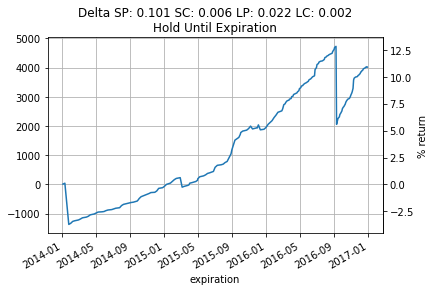

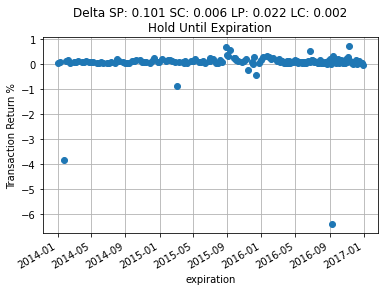

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2016-12-29,2016-12-30,0.101189,2225.0,0.074434,40.0,0.005747,2320.0,0.0057,5.0,0.002255,2340.0,0.002163,-5.0,0.022086,2200.0,0.018138,-10.0,4,30.0


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2016-12-29,2016-12-30,0.04,2215.0,0.036935,20.0,0.02,2290.0,0.016958,15.0,2,35.0
